## Encoder-decoder architecture

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

In [4]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F


## Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. 

- Data will be tokenized with WordPunctTokenizer.
- Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence.
- One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [2]:
%%capture
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

In [5]:
!head -n 5 data.txt

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.
At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.	В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.
Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.	Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.
Each has a TV and a private bathroom with shower.	В вашем распоряжении также телевизор и собственная ванная комната с душем.
Your room comes with air conditioning and satellite TV.	Номер оснащен кондиционером и спутниковым телевидением.


### Tokenizing & applying BPE rules

In [6]:
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

In [7]:
# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)  # 1. learn_bpe rules
    bpe[lang] = BPE(open('./bpe_rules.' + lang))  # 2. create instance of BPE class
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')  # 3. apply BPE tokenization to our data

100%|██████████| 8000/8000 [00:14<00:00, 538.33it/s]


In [8]:
# first 3 lines of our BPE tokenized English data:
!head -n 3 /content/train.bpe.en 

cor@@ del@@ ia hotel is situated in tbilisi , a 3 - minute walk away from saint trinity church .
at tu@@ pi@@ r@@ mar@@ ka lodge you will find a 24 - hour front desk , room service , and a snack bar .
featuring free wifi in all areas , nai@@ g@@ ao xiao@@ wo offers accommodation in shanghai .


In [9]:
# first 3 lines of our BPE tokenized Russian data:
!head -n 3 /content/train.bpe.ru 

отель cor@@ del@@ ia расположен в тбилиси , в 3 минутах ходьбы от свя@@ то - тро@@ и@@ ц@@ кого собора .
в числе удобств лоджа tu@@ p@@ ir@@ mar@@ ka круглосуточная стойка регистрации и снэк - бар . гости могут воспользоваться услугой доставки еды и напитков в номер .
апартаменты na@@ i@@ ga@@ o xi@@ a@@ ow@@ o расположены в городе шан@@ хай . к услугам гостей бесплатный wi - fi во всех зонах .


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa.   
We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [10]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [12]:
from vocab import Vocab

inp_voc = Vocab.from_lines(train_inp) # creates an instance of Vocab class from input lines (ru (input) vocab here)
out_voc = Vocab.from_lines(train_out) # en (output) vocab

print(f'Length of input (Russian) BPE vocabulary = {len(inp_voc)}')
print(f'Length of output (English) BPE vocabulary = {len(out_voc)}')

Length of input (Russian) BPE vocabulary = 8048
Length of output (English) BPE vocabulary = 7801


In [17]:
# Here's how you cast lines into ids and backwards.

batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

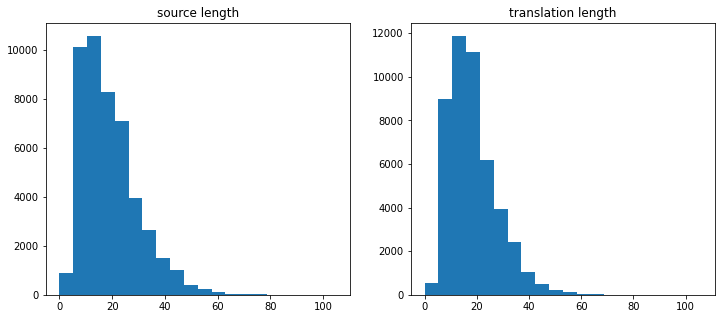

In [25]:
plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

The code below contains a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything.

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [27]:
from models import BasicModel

model = BasicModel(inp_voc, out_voc).to(device)

# debugging area

dummy_inp_tokens = inp_voc.to_matrix(train_inp[:5]).to(device)
dummy_out_tokens = out_voc.to_matrix(train_out[:5]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [153]:
h0[0].size()

torch.Size([7, 128])

In [54]:
len(h0)

1

In [43]:
states = [deepcopy([h0[0].detach()]) for _ in range(2)]

In [46]:
len(states[0])

1

In [70]:
inp_voc.bos_ix

0

In [156]:
# Function in progress
hypos, outputs, states = model.decode_inference_beam_search(h0, beam_size=4)

4
[(0, 7395, 7279, 673, 658, 6244, 5421, 5021, 4348, 5295, 1376, 5991, 6922, 2711, 921, 681, 6926, 3986, 5395, 2296, 1153, 5213, 114, 2711, 7387, 1405, 6969, 4447, 4472, 1845, 4049, 6820, 2330, 5091, 7083, 2943, 4308, 7758, 2403, 879, 3825, 4060, 1780, 33, 4330, 4290, 4017, 1866, 6325, 4216, 503, 4398, 2844, 3210, 5616, 2052, 6498, 2942, 5268, 409, 278, 3368, 2573, 5317, 166, 1132, 4551, 3052, 5471, 764, 3229, 6782, 2626, 5386, 6227, 858, 2942, 7071, 7282, 4839, 4143, 270, 7395, 1329, 4700, 2618, 70, 7031, 505, 2581, 5273, 7753, 1721, 4119, 2237, 6584, 3498, 3837, 2314, 7631, 2640), (0, 6819, 6249, 7523, 3675, 3675, 4839, 6604, 7127, 31, 3219, 1949, 658, 2325, 2229, 6371, 3486, 1139, 6724, 3586, 1253, 6533, 5399, 221, 2303, 7109, 6935, 5182, 3711, 858, 872, 7607, 919, 548, 7712, 2245, 7614, 1914, 5271, 1181, 5555, 6196, 3283, 1555, 5704, 1555, 592, 1301, 5571, 3575, 4197, 1062, 5644, 3180, 3180, 5740, 6069, 31, 1244, 3825, 6373, 3372, 4457, 2991, 5112, 2942, 2753, 5412, 764, 104, 6675,

In [178]:
outputs, states = model.decode_inference_beam_search(h0, beam_size=4)

In [ ]:
out_voc.to_lines(out_ids)

In [180]:
out_voc.to_lines(outputs)

['whe@@ wifi east@@ ü skiy 18@@ shopping tes@@ specialities english nier pin@@ riccione yar@@ classics bid@@ coloured świ@@ pier tera ise hai@@ possibil@@ riccione balaton excur@@ dar politan heath@@ rah lido fresco solo@@ garten vin composed ston stral@@ ved william brand@@ sa@@ stral@@ ever@@ ang@@ date laus@@ sund@@ serving designated mere k@@ reap basic bo@@ writing vene@@ east@@ 18@@ mand@@ pin@@ nier ambi@@ gau terrac@@ gau grac@@ chand@@ ë welsh connecting tsentral@@ abil@@ ast@@ ke@@ hamilton 6@@ 6@@ youth ami lug@@ hired raised northern break is@@ historical mma specialises nest@@ fort@@ can@@ reland cave deo vak@@ ek ec@@ ballet sils',
 'imperial thos pian create sunbathing avignon plantation serving der@@ pico brindisi massage qingdao vari@@ quar@@ temp@@ featured ang@@ dishwasher ach@@ stays ental el@@ newspapers coo@@ bian lug@@ belo queenstown pin@@ braga ke@@ pin ham sundays backpackers split veg@@ umo@@ ma ova yad@@ skoy also politan sande interesting riccione 90 mary s

In [114]:
len(out_ids)

3

In [97]:
len(states)

2

In [100]:
states[0][0].size()

torch.Size([3, 128])

In [193]:
train_inp[:3]

array(['на территории обустроена бесплатная частная парковка .',
       'кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .',
       'отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .'],
      dtype='<U524')

In [37]:
%%time
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25, device=device)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
% ario kim@@ inn shei@@ capital ingen tianjin italy radi@@ cook@@ crow@@ recommend cartagena dro@@ atlant@@ schö@@ karl@@ croissants û@@ it@@ original cakes jam@@ kets
% ario kim@@ inn shei@@ capital ingen tianjin italy radi@@ cook@@ crow@@ recommend cartagena dro@@ atlant@@ schö@@ karl@@ croissants û@@ it@@ original cakes jam@@ kets
% ario str@@ ics scenic cic@@ bor paved bor mission free@@ free@@ ions one@@ size ues sig@@ radio dis ps str@@ including 000 petrov@@ who
CPU times: user 39.1 ms, sys: 0 ns, total: 39.1 ms
Wall time: 61.9 ms


In [39]:
%%time
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25, beam_size=2, device=device)
print("Translations with beam search:")
print('\n'.join([line for line in dummy_translations]))

Translations with beam search:
ž mission free@@ dispos@@ !@@ qingdao id@@ goa sonville zurich offers ní 19th eiro acces@@ hired + radi@@ nou@@ ec ven ying novorossiysk ari@@ tatami
ž mission free@@ dispos@@ !@@ qingdao id@@ goa sonville zurich offers ní 19th eiro acces@@ hired + radi@@ nou@@ ec ven ying novorossiysk ari@@ tatami
ž mission free@@ dispos@@ !@@ qingdao id@@ goa sonville zurich offers ní 19th eiro acces@@ hired + radi@@ nou@@ ec ven ying novorossiysk ari@@ tatami
CPU times: user 70.1 ms, sys: 0 ns, total: 70.1 ms
Wall time: 71.8 ms


### Training loss (2 points)

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [1]:
from utils import compute_loss

In [2]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 8.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

NameError: ignored

### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [44]:
from utils import compute_bleu

In [45]:
compute_bleu(model, dev_inp, dev_out)

NameError: ignored

In [26]:
compute_bleu(model, dev_inp, dev_out, beam_size=2)

0.0021352281114617655

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [27]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from utils import save_checkpoint, load_checkpoint

model = BasicModel(inp_voc, out_voc).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [29]:
def train_loop(model, optimizer, train_inp, num_epochs=25000, from_checkpoint=False):   

    metrics = {'train_loss': [], 'dev_bleu': [] }

    if from_checkpoint:
        best_checkpoint = torch.load('/content/best_bleu_state.pth')
        model.load_state_dict(best_checkpoint["state_dict"])
        best_bleu = best_checkpoint['bleu']
    else:
        best_bleu = 0

    for epoch in trange(num_epochs):
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
        
        optimizer.zero_grad() # set the gradients to zero before backpropagation
        loss_t = compute_loss(model, batch_inp, batch_out)
        loss_t.backward()
        optimizer.step()

        
        metrics['train_loss'].append((epoch+1, loss_t.item()))
        
        if (epoch+1) % 100 == 0:
            bleu = compute_bleu(model, dev_inp, dev_out)
            metrics['dev_bleu'].append((epoch+1, bleu))
            
            if bleu > best_bleu:
                best_bleu = bleu
                checkpoint = {
                    'state_dict' : deepcopy(model.state_dict()), 
                    'optimizer' : deepcopy(optimizer.state_dict()),
                    'epoch' : epoch+1,
                    'bleu' : bleu,
                }
                save_checkpoint(checkpoint, filename="best_bleu_state.pth")

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    
    return metrics

In [30]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=25000,
    from_checkpoint=False
)

 40%|███▉      | 9999/25000 [12:20<18:31, 13.50it/s]


KeyboardInterrupt: ignored

In [ ]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

print('Mean BLEU on last 10 epoches = ', np.mean(metrics['dev_bleu'][-10:], axis=0)[1]) # Simple GRU model without attention

best BLEU =  17.98508599619603
best epoch =  15600


In [39]:
def beam_research(model, inp, out, model_name, beam_min=2, beam_max=10):
    """BLEU scores of a model with different beam_size"""
    
    beam_range = range(beam_min, beam_max + 1)
    blue_scores = []

    for beam_size in beam_range:
        blue = compute_bleu(model, inp, out, beam_size=beam_size)
        blue_scores.append(blue)

    plt.figure(figsize=(7, 5))
    plt.plot(beam_range, blue_scores)
    plt.title('Beam search results for %s' % model_name)
    plt.xticks(beam_range)
    plt.xlabel('beam size')
    plt.ylabel('blue score')
    plt.show()

In [32]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device='cuda')[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: you will find a shared kitchen and a shared kitchen at the property .
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: other facilities offered at the property include free parking .
target line: bicycle rental and shuttle services are also available . the property offers free parking .

input line: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
translated line: brindisi is 11 km from the property .
target line: the unit is 26 km from kissimmee .

input line: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
translated line: located in a quiet area , just a 5 - minute walk from the beach , villa vision offers self - cater

In [35]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device='cuda', beam_size=2)[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: there are a common lounge and hairdresser ’ a laundry service at a surcharge and is also . a cash tions at this guest . guests will also have a bicycle rental facilities for guests to explore guests at their stay at additional charge in . guests are available for a fee and free entry . the hotel offers free parking is possible on the premises
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: the hostel in a bicycle and bicycle rentals can also rent bicycles for guests to use the car rental and car rental services are offered at this hotel and guests receive free of the hotel in a car rental service for guests to the free shuttle . free parking spaces . the hotel offers a free transfer . the nearest grocery shop and a private parking are located ava

In [40]:
%time beam_research(model, dev_inp, dev_out, 'basic model')

KeyboardInterrupt: ignored

In [ ]:
# Why changing number?

# input line: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
# translated line: the city of santander is 5 km away .

for out_line in dev_out:
    if ('is 5 km' in out_line):
        print(out_line)

# Answer: Where's a sample in training set (dev_out) which has 'is 5 km' 
#  ... is 5 km from ...

# Thus, the model remember 'is' with '5 km away'

zo@@ ag@@ li train station is 900 metres from the mare zo@@ ag@@ li . ra@@ pal@@ lo is 5 km away .
novosibirsk state circus is 2 . 6 km from apartment on vo@@ en@@ naya , while novosibirsk zoo is 5 km away .
set in her@@ mag@@ or , haus ei@@ ch@@ horn ferienwohnung offers self - catering accommodation with free wifi . featuring free private parking , the apartment is 5 km from lake pres@@ seg@@ ger .
lake pi@@ ch@@ ho@@ la is 4 . 1 km from sin@@ gh@@ i villa guest house , while city palace of ud@@ aipur is 5 km away .
salzburg is 5 km from las@@ chen@@ sky depend@@ ance , while berchtesgaden is 16 km away .
hotel sto@@ mi@@ o beach is 5 km from kim@@ i harbour and at a distance of 180 km from athens city centre .
parc des ex@@ posit@@ ions de metz is 5 km from bo@@ he@@ me ap@@ part , while sta@@ de saint - sy@@ mp@@ hori@@ en is 1 . 1 km from the property . metz - nan@@ cy - lor@@ ra@@ ine airport is 15 km away .
the blu gro@@ tto is 5 km away .
situated in the pat@@ el complex , hote

**QUESTION:** How to tackle this problem with numbers?  
**ANSWER:** Add attention / train more

# Attention layer

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()

        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity
        
        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.soft = nn.Softmax(dim=-1)
        
    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, n_inp, enc_size = enc.shape

        tmp = self.linear_dec(dec) # [batch_size, hid_size]
        tmp = tmp.reshape(-1, 1, self.hid_size) # [batch_size, 1, hid_size]

        # a_t = Linear_out(tanh(Linear_enc(h_enc_t) + Linear_dec(h_dec)))

        x = self.linear_enc(enc) # [batch_size, ninp, hid_size] 
        x = self.activ(x + tmp) # [batch_size, ninp, hid_size]
        x = self.linear_out(x) # [batch_size, ninp, 1] 
        # now x is [a0,..,a_t,...,a_T] matrix

        # Compute attention probabilities (softmax)
        probs = self.soft(x.reshape(batch_size, n_inp))        
        
        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, n_inp, 1) * enc).sum(axis=1)

        return attn, probs

### Seq2seq model with attention (3 points)

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128, bid=False):
        """ Translation model that uses attention. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        
        # We could've used these 3 functions below from BasicModel, but here we add bidirectionality
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=bid)
        self.dec_start = nn.Linear(hid_size + hid_size * bid, hid_size)
        self.Wc = nn.Linear(emb_size + hid_size + hid_size * bid, emb_size + hid_size + hid_size * bid)
        self.dec0 = nn.GRUCell(emb_size + hid_size + hid_size * bid, hid_size)
        self.attn = AttentionLayer(hid_size + hid_size * bid, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """

        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb) 
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state) # initial state for decoder

        # compute mask for input sequence
        enc_mask = self.out_voc.compute_mask(inp)

        # apply attention layer from initial decoder hidden state 
        _, first_attn_probas = self.attn(enc_seq, dec_start, enc_mask)
        
        return [dec_start, enc_seq, enc_mask, first_attn_probas]
   

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        
        prev_gru0_state, enc_seq, enc_mask, first_attn_probas = prev_state
        attn, attn_probs = self.attn(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        
        x = torch.cat([attn, x], dim=-1)
        x = torch.tanh(self.Wc(x))
        x = self.dec0(x, prev_gru0_state)
        
        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        
        return new_dec_state, output_logits

### Training attentive model

Reusing the structure we've built for the regular model.

In [ ]:
#<YOUR CODE: create AttentiveModel and training utilities>
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

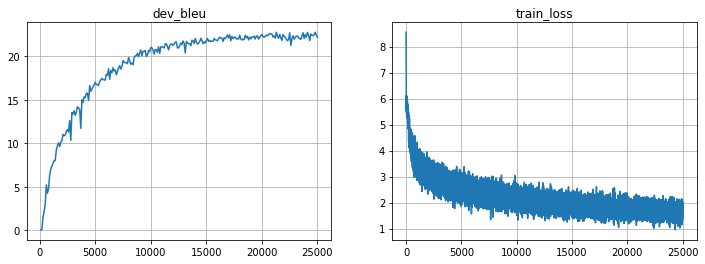

Mean loss=1.716


100%|██████████| 25000/25000 [39:57<00:00, 10.43it/s]


In [ ]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=25000,
    from_checkpoint=False
)

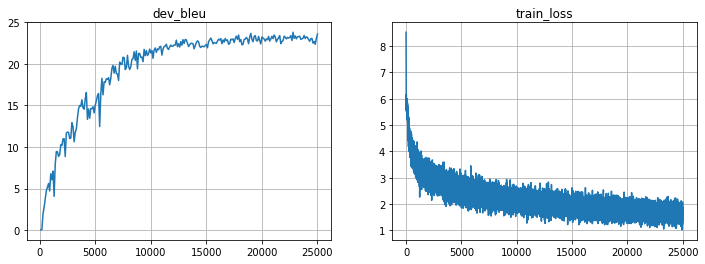

Mean loss=1.641


100%|██████████| 25000/25000 [40:47<00:00, 10.21it/s]


In [ ]:
# training loop

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    #<YOUR CODE: training step using batch_inp and batch_out>
    optimizer.zero_grad() # set the gradients to zero before backpropagation
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    optimizer.step()

    
    metrics['train_loss'].append((step, loss_t.item()))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [ ]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

best BLEU =  22.752529507906143
best epoch =  24800


In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [ ]:
# Mean BLEU on last 10 epoches (Simple GRU model without attention)
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

22.407775743721057

In [ ]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device='cuda')[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: there is a shared kitchen and shared shared kitchen .
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: bike rental and car rental are available at the property and free parking .
target line: bicycle rental and shuttle services are also available . the property offers free parking .

input line: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
translated line: the town of rethymno is 26 km away .
target line: the unit is 26 km from kissimmee .

input line: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
translated line: offering a barbecue and a garden , the apartment is situated in a quiet area in the complex of the sea 

__My comment:__   
As we can see, the translation is way better now.  
Our model also translated the line __'составляет 26 км' --> 'is 26 km from property'__ correctly.

====test==== (Without linear Wc)

In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128, bid=False):
        """ Translation model that uses attention. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        
        # We could've used these 3 functions below from BasicModel, but here we add bidirectionality
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=bid)
        self.dec_start = nn.Linear(hid_size + hid_size * bid, hid_size)
        self.Wc = nn.Linear(emb_size + hid_size + hid_size * bid, emb_size + hid_size + hid_size * bid)
        self.dec0 = nn.GRUCell(emb_size + hid_size + hid_size * bid, hid_size)
        self.attn = AttentionLayer(hid_size + hid_size * bid, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """

        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb) 
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state) # initial state for decoder

        # compute mask for input sequence
        enc_mask = self.out_voc.compute_mask(inp)

        # apply attention layer from initial decoder hidden state 
        _, first_attn_probas = self.attn(enc_seq, dec_start, enc_mask)
        
        return [dec_start, enc_seq, enc_mask, first_attn_probas]
   

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        
        prev_gru0_state, enc_seq, enc_mask, first_attn_probas = prev_state
        attn, attn_probs = self.attn(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)
        
        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        
        return new_dec_state, output_logits

In [ ]:
#<YOUR CODE: create AttentiveModel and training utilities>
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

NameError: ignored

In [ ]:
from train import train_loop

In [ ]:
train_loop(model, train_inp, num_epochs=500, batch_size=32, from_checkpoint=False)

NameError: ignored

In [ ]:
# training loop

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    #<YOUR CODE: training step using batch_inp and batch_out>
    optimizer.zero_grad() # set the gradients to zero before backpropagation
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    optimizer.step()

    
    metrics['train_loss'].append((step, loss_t.item()))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

=======================

### Visualizing model attention (2 points)

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please save at least 3 attention maps and __submit them to anytask__ alongside this notebook to get the max grade. Saving bokeh figures as __cell outputs is not enough!__ (TAs can't see saved bokeh figures in anytask). You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note:__ you're not locked into using bokeh. If you prefer a different visualization method, feel free to use that instead of bokeh.

In [ ]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

In [ ]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)
attention_probs = <YOUR CODE>

In [ ]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])
    
# Does it look fine already? don't forget to save images for anytask!

__Note 1:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.

__Note 2:__ If you're studying this course as a YSDA student, please submit __attention screenshots__ alongside your notebook.

## Goind deeper (2++ points each)

We want you to find the best model for the task. Use everything you know.

* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder (additive, dot-product, multi-head)
* word dropout, training schedules, anything you can imagine
* replace greedy inference with beam search

For a better grasp of seq2seq We recommend you to conduct at least one experiment from one of the bullet-points or your alternative ideas. As usual, describe what you tried and what results you obtained in a short report.

`[your report/log here or anywhere you please]`